In [ ]:
# Various torch packages
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split

# torchvision
from torchvision import datasets, transforms

# ------------------------
# get up one directory
import sys, os
sys.path.append(os.path.abspath('../'))
# ------------------------
!pip install torchmetrics
# custom packages
import models.aux_funs as maf
from models.unet import UNet
import optimizers as op
import regularizers as reg
import train
import math
import utils.configuration as cf
import utils.datasets as ud

import torchmetrics as TM
import matplotlib.pyplot as plt

# Fix the random seed

In [ ]:
random_seed = 0
cf.seed_torch(random_seed)

# Configure the experiment

In [ ]:
conf_args = {#
    # data specification
    'data_file':"../../datasets",'train_split':0.95, 'data_set':"Fashion-MNIST", 'download':True,
    # cuda
    'use_cuda':False, 'num_workers':4, 'cuda_device':0, 'pin_memory':True, 'train_split':0.95,
    #
    'epochs':20,
    # optimizer
    'delta':1.0, 'lr':0.1, 'lamda_0':0.01, 'lamda_1':0.01, 'optim':"AdaBreg", 'conv_group':True,
    'beta':0.1,
    # initialization
    'sparse_init':0.05, 'r':[10.,10.,10.],
    # misc
    'random_seed':random_seed, 'eval_acc':True,
}

conf = cf.Conf(**conf_args)

# Initiate the model

In [ ]:
model_kwargs = {'mean':conf.data_set_mean, 'std':conf.data_set_std}

model = UNet(n_channels=3, n_classes=3)

# Weight initialization

In [ ]:
def init_weights(conf, model):
    # sparsify
    maf.sparse_bias_uniform_(model, 0, conf.r[0])
    maf.sparse_bias_uniform_(model, 0, conf.r[0], ltype=torch.nn.Conv2d)
    maf.sparse_weight_normal_(model, conf.r[1])
    maf.sparse_weight_normal_(model, conf.r[2], ltype=torch.nn.Conv2d)
    #
    maf.sparsify_(model, conf.sparse_init, ltype=nn.Conv2d, conv_group=conf.conv_group)
    maf.sparsify_(model, conf.sparse_init, ltype=nn.Linear)
    model = model.to(conf.device)
    return model


# Initialize the weights
model = init_weights(conf, model)

# Optimizer

In [ ]:
def init_opt(conf, model):
    # -----------------------------------------------------------------------------------
    # Get access to different model parameters
    # -----------------------------------------------------------------------------------
    weights_conv = maf.get_weights_conv(model)
    weights_linear = maf.get_weights_linear(model)
    biases = maf.get_bias(model)

    # -----------------------------------------------------------------------------------
    # Initialize optimizer
    # -----------------------------------------------------------------------------------
    if conf.conv_group:
        reg2 = reg.reg_l1_l2_conv(lamda=conf.lamda_0)
    else:
        reg2 = reg.reg_l1(lamda=conf.lamda_0)

    if conf.optim == "SGD":
        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta)
    elif conf.optim == "LinBreg":
        opt = op.LinBreg(
            [
                {'params': weights_conv, 'reg': reg2},
                {'params': weights_linear, 'reg': reg.reg_l1(lamda=conf.lamda_1)},
                {'params': biases}
            ],
            lr=conf.lr,
            delta=conf.delta,
            momentum=conf.beta
        )
    elif conf.optim == "ProxSGD":
        opt = op.ProxSGD(
            [
                {'params': weights_conv, 'lr': conf.lr, 'reg': reg2, 'momentum': conf.beta, 'delta': conf.delta},
                {'params': weights_linear, 'lr': conf.lr, 'reg': reg.reg_l1(lamda=conf.lamda_1), 'momentum': conf.beta, 'delta': conf.delta},
                {'params': biases, 'lr': conf.lr, 'momentum': conf.beta}
            ]
        )
    elif conf.optim == "AdaBreg":
        opt = op.AdaBreg(
            [
                {'params': weights_conv, 'lr': conf.lr, 'reg': reg2, 'delta': conf.delta},
                {'params': weights_linear, 'lr': conf.lr, 'reg': reg.reg_l1(lamda=conf.lamda_1), 'delta': conf.delta},
                {'params': biases, 'lr': conf.lr}
            ]
        )
    elif conf.optim == "L1SGD":
        def weight_reg(model):
            reg1 = reg.reg_l1(lamda=conf.lamda_1)

            loss1 = reg1(model.layers2[0].weight) + reg1(model.layers2[2].weight)
            loss2 = reg2(model.layers1[0].weight) + reg2(model.layers1[3].weight)
            return loss1 + loss2

        conf.weight_reg = weight_reg

        opt = torch.optim.SGD(model.parameters(), lr=conf.lr, momentum=conf.beta)
    else:
        raise ValueError("Unknown Optimizer specified")

    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, factor=0.5, patience=5, threshold=0.01)

    return opt, scheduler


# Dataset

In [ ]:
import torchvision
import os
working_dir = "/content/data"
pets_path_train = os.path.join(working_dir, 'OxfordPets', 'train')
pets_path_test = os.path.join(working_dir, 'OxfordPets', 'test')
pets_train_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_train, split="trainval", target_types="segmentation", download=True)
pets_test_orig = torchvision.datasets.OxfordIIITPet(root=pets_path_test, split="test", target_types="segmentation", download=True)

100%|██████████| 791918971/791918971 [00:26<00:00, 30350232.58it/s]


Extracting /content/data/OxfordPets/train/oxford-iiit-pet/images.tar.gz to /content/data/OxfordPets/train/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 15264227.01it/s]


Extracting /content/data/OxfordPets/train/oxford-iiit-pet/annotations.tar.gz to /content/data/OxfordPets/train/oxford-iiit-pet


100%|██████████| 791918971/791918971 [00:20<00:00, 38101000.98it/s]


Extracting /content/data/OxfordPets/test/oxford-iiit-pet/images.tar.gz to /content/data/OxfordPets/test/oxford-iiit-pet


100%|██████████| 19173078/19173078 [00:01<00:00, 15087669.83it/s]


Extracting /content/data/OxfordPets/test/oxford-iiit-pet/annotations.tar.gz to /content/data/OxfordPets/test/oxford-iiit-pet


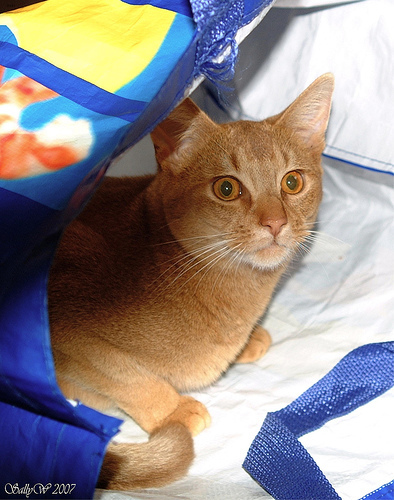

In [ ]:
(train_pets_input, train_pets_target) = pets_train_orig[0]
# Spot check an input image.
train_pets_input

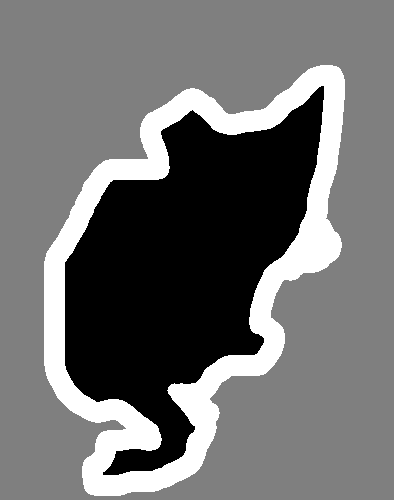

In [ ]:
import torchvision.transforms as T
# Convert a pytorch tensor into a PIL image
t2img = T.ToPILImage()
# Convert a PIL image into a pytorch tensor
img2t = T.ToTensor()

from enum import IntEnum
class TrimapClasses(IntEnum):
    PET = 0
    BACKGROUND = 1
    BORDER = 2

# Convert a float trimap ({1, 2, 3} / 255.0) into a float tensor with
# pixel values in the range 0.0 to 1.0 so that the border pixels
# can be properly displayed.
def trimap2f(trimap):
    return (img2t(trimap) * 255.0 - 1) / 2

t2img(trimap2f(train_pets_target))

In [ ]:
# Create a dataset wrapper that allows us to perform custom image augmentations
# on both the target and label (segmentation mask) images.
#
# These custom image augmentations are needed since we want to perform
# transforms such as:
# 1. Random horizontal flip
# 2. Image resize
#
# and these operations need to be applied consistently to both the input
# image as well as the segmentation mask.
class OxfordIIITPetsAugmented(torchvision.datasets.OxfordIIITPet):
    def __init__(
        self,
        root: str,
        split: str,
        target_types="segmentation",
        download=False,
        pre_transform=None,
        post_transform=None,
        pre_target_transform=None,
        post_target_transform=None,
        common_transform=None,
    ):
        super().__init__(
            root=root,
            split=split,
            target_types=target_types,
            download=download,
            transform=pre_transform,
            target_transform=pre_target_transform,
        )
        self.post_transform = post_transform
        self.post_target_transform = post_target_transform
        self.common_transform = common_transform

    def __len__(self):
        return super().__len__()

    def __getitem__(self, idx):
        (input, target) = super().__getitem__(idx)

        # Common transforms are performed on both the input and the labels
        # by creating a 4 channel image and running the transform on both.
        # Then the segmentation mask (4th channel) is separated out.
        if self.common_transform is not None:
            both = torch.cat([input, target], dim=0)
            both = self.common_transform(both)
            (input, target) = torch.split(both, 3, dim=0)
        # end if

        if self.post_transform is not None:
            input = self.post_transform(input)
        if self.post_target_transform is not None:
            target = self.post_target_transform(target)

        return (input, target)



In [ ]:
# Create a tensor for a segmentation trimap.
# Input: Float tensor with values in [0.0 .. 1.0]
# Output: Long tensor with values in {0, 1, 2}
from torch.utils.data import DataLoader, Subset
def tensor_trimap(t):
    x = t * 255
    x = x.to(torch.long)
    x = x - 1
    return x

def args_to_dict(**kwargs):
    return kwargs

transform_dict = args_to_dict(
    pre_transform=T.ToTensor(),
    pre_target_transform=T.ToTensor(),
    common_transform=T.Compose([T.Resize((128, 128), interpolation=T.InterpolationMode.NEAREST),
        # Random Horizontal Flip as data augmentation.
        T.RandomHorizontalFlip(p=0.5),
    ]),
    post_transform=T.Compose([
        # Color Jitter as data augmentation.
        T.ColorJitter(contrast=0.3),
    ]),
    post_target_transform=T.Compose([
        T.Lambda(tensor_trimap),
    ]),
)

# Create the train and test instances of the data loader for the
# Oxford IIIT Pets dataset with random augmentations applied.
# The images are resized to 128x128 squares, so the aspect ratio
# will be chaged. We use the nearest neighbour resizing algorithm
# to avoid disturbing the pixel values in the provided segmentation
# mask.
pets_train = OxfordIIITPetsAugmented(
    root=pets_path_train,
    split="trainval",
    target_types="segmentation",
    download=False,
    **transform_dict,
)
pets_test = OxfordIIITPetsAugmented(
    root=pets_path_test,
    split="test",
    target_types="segmentation",
    download=False,
    **transform_dict,
)

batch_size_train = 32
batch_size_test = 21

num_samples_train = 30 * batch_size_train
num_samples_test = 30 * batch_size_test

# Create subsets of the datasets
train_subset = Subset(pets_train, range(num_samples_train))
test_subset = Subset(pets_test, range(num_samples_test))

pets_train_loader = torch.utils.data.DataLoader(
    train_subset,
    batch_size=32,
    shuffle=True,
)
pets_test_loader = torch.utils.data.DataLoader(
    test_subset,
    batch_size=21,
    shuffle=True,
)

(train_pets_inputs, train_pets_targets) = next(iter(pets_train_loader))
(test_pets_inputs, test_pets_targets) = next(iter(pets_test_loader))
train_pets_inputs.shape, train_pets_targets.shape

(torch.Size([32, 3, 128, 128]), torch.Size([32, 1, 128, 128]))

In [ ]:
def get_model_parameters(m):
    total_params = sum(
        param.numel() for param in m.parameters()
    )
    return total_params

def print_model_parameters(m):
    num_model_parameters = get_model_parameters(m)
    print(f"The Model has {num_model_parameters/1e6:.2f}M parameters")
# end if

def close_figures():
    while len(plt.get_fignums()) > 0:
        plt.close()
    # end while
# end def
def IoUMetric(pred, gt, softmax=False):
    # Run softmax if input is logits.
    if softmax is True:
        pred = nn.Softmax(dim=1)(pred)
    # end if

    # Add the one-hot encoded masks for all 3 output channels
    # (for all the classes) to a tensor named 'gt' (ground truth).
    gt = torch.cat([ (gt == i) for i in range(3) ], dim=1)
    # print(f"[2] Pred shape: {pred.shape}, gt shape: {gt.shape}")

    intersection = gt * pred
    union = gt + pred - intersection

    # Compute the sum over all the dimensions except for the batch dimension.
    iou = (intersection.sum(dim=(1, 2, 3)) + 0.001) / (union.sum(dim=(1, 2, 3)) + 0.001)

    # Compute the mean over the batch dimension.
    return iou.mean()

def prediction_accuracy(ground_truth_labels, predicted_labels):
    eq = ground_truth_labels == predicted_labels
    return eq.sum().item() / predicted_labels.numel()

def print_test_dataset_masks(model, test_pets_targets, test_pets_labels, epoch, save_path, show_plot):
    model.eval()
    predictions = model(test_pets_targets)
    test_pets_labels = test_pets_labels
    # print("Predictions Shape: {}".format(predictions.shape))
    pred = nn.Softmax(dim=1)(predictions)

    pred_labels = pred.argmax(dim=1)
    # Add a value 1 dimension at dim=1
    pred_labels = pred_labels.unsqueeze(1)
    # print("pred_labels.shape: {}".format(pred_labels.shape))
    pred_mask = pred_labels.to(torch.float)

    # accuracy = prediction_accuracy(test_pets_labels, pred_labels)
    iou =TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND)
    iou_accuracy = iou(pred_mask, test_pets_labels)
    pixel_metric =TM.classification.MulticlassAccuracy(3, average='micro')
    pixel_accuracy = pixel_metric(pred_labels, test_pets_labels)
    custom_iou = IoUMetric(pred, test_pets_labels)
    conv_sparse = maf.conv_sparsity(model)
    linear_sparse = maf.linear_sparsity(model)
    net_sparse = maf.net_sparsity(model)
    node_sparse = maf.node_sparsity(model)
    title = (f'Epoch: {epoch:02d}, Accuracy[Pixel: {pixel_accuracy:.4f}, IoU: {iou_accuracy:.4f}, Custom IoU: {custom_iou:.4f}], '
         f'Sparsity[Conv: {conv_sparse:.4f}, Linear: {linear_sparse:.4f}, Net: {net_sparse:.4f}, Node: {node_sparse:.4f}]')
    print(title)
    # print(f"Accuracy: {accuracy:.4f}")

    # Close all previously open figures.
    close_figures()

    fig = plt.figure(figsize=(10, 12))
    fig.suptitle(title, fontsize=12)

    fig.add_subplot(3, 1, 1)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_targets, nrow=7)))
    plt.axis('off')
    plt.title("Targets")

    fig.add_subplot(3, 1, 2)
    plt.imshow(t2img(torchvision.utils.make_grid(test_pets_labels.float() / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Ground Truth Labels")

    fig.add_subplot(3, 1, 3)
    plt.imshow(t2img(torchvision.utils.make_grid(pred_mask / 2.0, nrow=7)))
    plt.axis('off')
    plt.title("Predicted Labels")

    if save_path is not None:
        plt.savefig(os.path.join(save_path, f"epoch_{epoch:02}.png"), format="png", bbox_inches="tight", pad_inches=0.4)
    # end if

    if show_plot is False:
        close_figures()
    else:
        plt.show()
    # end if
# end def

def test_dataset_accuracy(model, loader):
    model.eval()
    iou = TM.classification.MulticlassJaccardIndex(3, average='micro', ignore_index=TrimapClasses.BACKGROUND)
    pixel_metric = TM.classification.MulticlassAccuracy(3, average='micro')

    iou_accuracies = []
    pixel_accuracies = []
    custom_iou_accuracies = []

    print_model_parameters(model)

    for batch_idx, (inputs, targets) in enumerate(loader, 0):
        predictions = model(inputs)

        pred_probabilities = nn.Softmax(dim=1)(predictions)
        pred_labels = predictions.argmax(dim=1)

        # Add a value 1 dimension at dim=1
        pred_labels = pred_labels.unsqueeze(1)
        # print("pred_labels.shape: {}".format(pred_labels.shape))
        pred_mask = pred_labels.to(torch.float)

        iou_accuracy = iou(pred_mask, targets)
        # pixel_accuracy = pixel_metric(pred_mask, targets)
        pixel_accuracy = pixel_metric(pred_labels, targets)
        custom_iou = IoUMetric(pred_probabilities, targets)
        iou_accuracies.append(iou_accuracy.item())
        pixel_accuracies.append(pixel_accuracy.item())
        custom_iou_accuracies.append(custom_iou.item())

        del inputs
        del targets
        del predictions
    # end for

    iou_tensor = torch.FloatTensor(iou_accuracies)
    pixel_tensor = torch.FloatTensor(pixel_accuracies)
    custom_iou_tensor = torch.FloatTensor(custom_iou_accuracies)

    print("Test Dataset Accuracy")
    print(f"Pixel Accuracy: {pixel_tensor.mean():.4f}, IoU Accuracy: {iou_tensor.mean():.4f}, Custom IoU Accuracy: {custom_iou_tensor.mean():.4f}")



Epoch: 00, Accuracy[Pixel: 0.3999, IoU: 0.3730, Custom IoU: 0.2542]


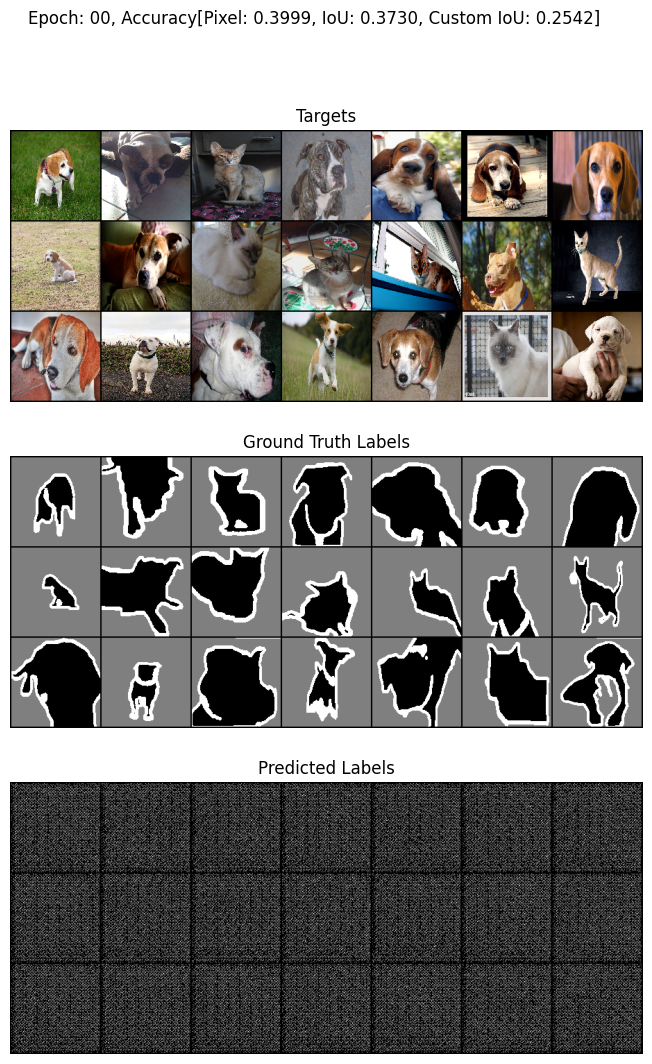

In [ ]:
save_path = os.path.join(working_dir, "segnet_basic_training_progress_images")
os.makedirs(save_path, exist_ok=True)
print_test_dataset_masks(model, test_pets_inputs, test_pets_targets, epoch=0, save_path=None, show_plot=True)

In [ ]:
# model_state_dict = torch.load('/content/sgd100.py')
# model.load_state_dict(model_state_dict)

# History and Runs

# Training

In [ ]:
import torch
import os


# # Step 4: Load the state dictionary into the model instance
# model.load_state_dict(model_state_dict)

# Initialize weights, optimizer, and scheduler
opt, scheduler = init_opt(conf, model)

def train_loop(model, train_loader, test_data, epochs, optimizer, scheduler, save_path, model_save_path):
    test_inputs, test_targets = test_data
    epoch_i, epoch_j = epochs
    for i in range(epoch_i, epoch_j):
        epoch = i
        print(f"Epoch: {i:02d}, Learning Rate: {optimizer.param_groups[0]['lr']}")
        training_data = train.train_step(conf, model, opt, train_loader)
        with torch.inference_mode():
            # Display the plt in the final training epoch.
            print_test_dataset_masks(model, test_inputs, test_targets, epoch=epoch, save_path=save_path, show_plot=(epoch == epoch_j-1))

        if scheduler is not None:
            scheduler.step(training_data['loss'])
        # end if
        print("")

    # Save the model
    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved at {model_save_path}")

save_path = os.path.join(working_dir, "segnet_basic_training_progress_images")
model_save_path = '/content/savedmodel'

train_loop(model, pets_train_loader, (test_pets_inputs, test_pets_targets), (0, 100), opt, scheduler, save_path, model_save_path)


Epoch: 00, Learning Rate: 0.1
Train Loss: 1.2124369489829575e+20
Epoch: 00, Accuracy[Pixel: 0.5733, IoU: 0.0000, Custom IoU: 0.2533]

Epoch: 01, Learning Rate: 0.1
Train Loss: 0.9342171589533488
Epoch: 01, Accuracy[Pixel: 0.5733, IoU: 0.0000, Custom IoU: 0.2851]

Epoch: 02, Learning Rate: 0.1
Train Loss: 0.9207972745100658
Epoch: 02, Accuracy[Pixel: 0.5732, IoU: 0.0000, Custom IoU: 0.2811]

Epoch: 03, Learning Rate: 0.1
Train Loss: 0.9211215297381083
Epoch: 03, Accuracy[Pixel: 0.5734, IoU: 0.0000, Custom IoU: 0.2908]

Epoch: 04, Learning Rate: 0.1
Train Loss: 0.9213673611481984
Epoch: 04, Accuracy[Pixel: 0.5734, IoU: 0.0000, Custom IoU: 0.2922]

Epoch: 05, Learning Rate: 0.1
Train Loss: 0.9223474661509196
Epoch: 05, Accuracy[Pixel: 0.5734, IoU: 0.0000, Custom IoU: 0.2840]

Epoch: 06, Learning Rate: 0.1
Train Loss: 0.9209485391775767
Epoch: 06, Accuracy[Pixel: 0.5734, IoU: 0.0000, Custom IoU: 0.2916]

Epoch: 07, Learning Rate: 0.1
Train Loss: 0.9222375790278117
Epoch: 07, Accuracy[Pixel

KeyboardInterrupt: 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.save(model.state_dict(), '/content/Linbreg100.lr0.1.sp0.05.reg0.01.py')

Epoch: 00, Accuracy[Pixel: 0.7111, IoU: 0.3814, Custom IoU: 0.4097]


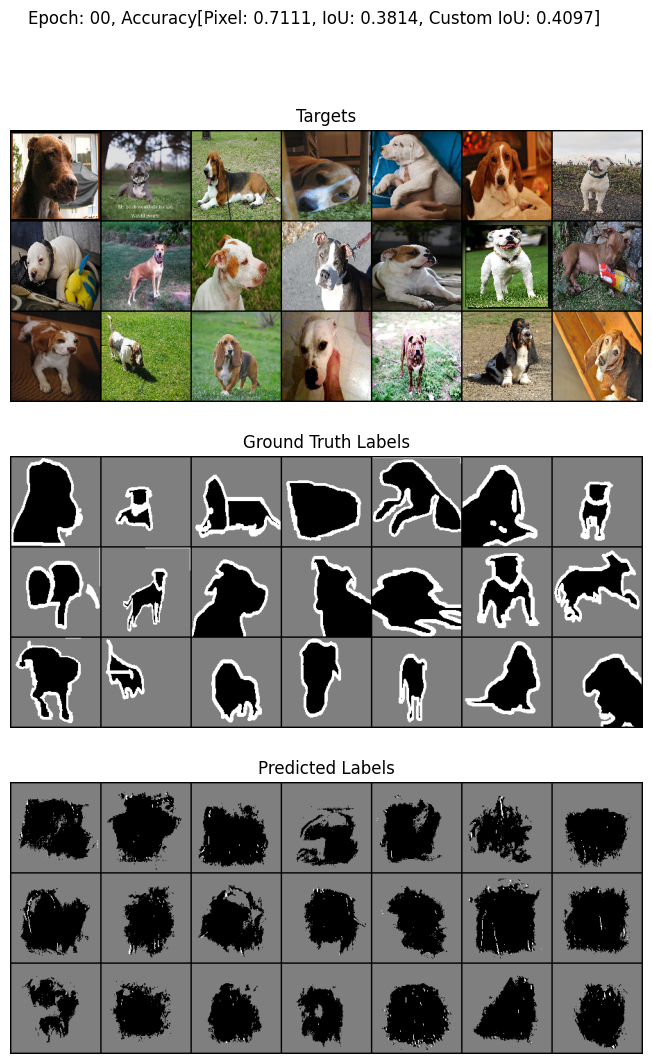

In [ ]:
# Step 3: Load the state dictionary
model_state_dict = torch.load('/content/80.py')

# Step 4: Load the state dictionary into the model instance
model.load_state_dict(model_state_dict)
print_test_dataset_masks(model, test_pets_inputs, test_pets_targets, epoch=0, save_path=None, show_plot=True)



# Evaluation

In [ ]:
# train.test(conf, best_model.best_model, test_loader)
# print(f'Convolution kernel sparsity: {maf.conv_sparsity(best_model.best_model)}')
# print(f'Linear sparsity: {maf.linear_sparsity(best_model.best_model)}')